# 2021/05/13

$\newcommand{\ket}[1]{| #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 |}$

## グローバーのアルゴリズムの実装

まず必要な環境をセットアップします。

In [1]:
# Tested with python 3.7.9, qiskit 0.23.5, numpy 1.20.1
import matplotlib.pyplot as plt
import numpy as np

# Qiskit関連のパッケージをインポート
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

### グローバーのアルゴリズムを実装する回路

6量子ビットの回路`grover_circuit`を準備します。

In [2]:
n = 6
grover_circuit = QuantumCircuit(n)

グローバー反復を一回実行する量子回路は以下のような構造になりますが、赤枠で囲んだ部分（オラクル$U_w$とDiffuserの中の$U_0=2\ket{0}\bra{0}-I$の部分）を実装する量子回路を書いてみましょう。

```{image} figs/grover_6bits_45.png
:alt: grover_6bits_45
:class: bg-primary mb-1
:width: 600px
:align: center
```

一様な重ね合わせ状態$\ket{s}$を生成した後に、オラクルを実装します。

In [3]:
def initialize_s(qc, qubits):
    """回路のqubitsにHゲートを適用"""
    for q in qubits:
        qc.h(q)
    return qc

grover_circuit = initialize_s(grover_circuit, list(range(n)))

# オラクルUwを作成して、回路に実装
oracle = QuantumCircuit(n)

##################
### EDIT BELOW ###
##################

# Oracle Uw?

##################
### EDIT ABOVE ###
##################

oracle_gate = oracle.to_gate()
oracle_gate.name = "U_w"

grover_circuit.append(oracle_gate, list(range(n)))

**解答例**

```python
oracle.x(1)
oracle.x(4)
oracle.h(n-1)
oracle.mct(list(range(n-1)), n-1)
oracle.h(n-1)
oracle.x(1)
oracle.x(4)
```

次に、Diffuser用の回路を実装します。

In [4]:
def diffuser(n):
    qc = QuantumCircuit(n)

    qc.h(range(n))

    ##################
    ### EDIT BELOW ###
    ##################

    # Unitary U0?

    ##################
    ### EDIT ABOVE ###
    ##################
    
    qc.h(range(n))

    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

**解答例**

```python
    #
    qc.rz(2*np.pi, n-1)
    qc.x(list(range(n)))

    # Multi-controlled Zゲート
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)

    qc.x(list(range(n)))
```

回路ができたので、printして確認してみます。

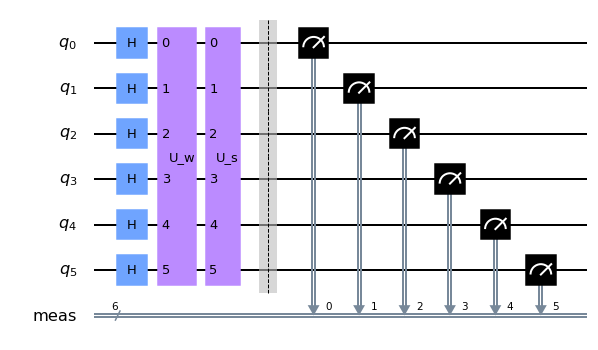

In [5]:
grover_circuit.append(diffuser(n), list(range(n)))
grover_circuit.measure_all()
grover_circuit.draw('mpl')

### シミュレータでの実験

回路の実装ができたら、シミュレータで実行して結果をプロットしてみます。結果が分かりやすくなるように、測定したビット列を整数にしてからプロットするようにしてみます。

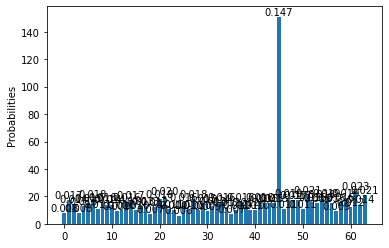

In [6]:
backend = Aer.get_backend('qasm_simulator')
results = execute(grover_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()

# 横軸を整数でプロットする
def show_distribution(answer):
    n = len(answer)
    x = [int(key,2) for key in list(answer.keys())]
    y = list(answer.values())

    fig, ax = plt.subplots()
    rect = ax.bar(x,y)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.3f}'.format(height/sum(y)),
                        xy=(rect.get_x()+rect.get_width()/2, height),xytext=(0,0),
                        textcoords="offset points",ha='center', va='bottom')
    autolabel(rect)
    plt.ylabel('Probabilities')
    plt.show()

show_distribution(answer)

正しく回路が実装できていれば、$\ket{101101}=\ket{45}$の状態を高い確率で測定できる様子を見ることができるでしょう。

### 量子コンピュータでの実験

では次に、この量子回路を実機の量子コンピュータで実行して、結果を確認してみましょう。

#### IBMQアカウントのアクティベーション

In [7]:
# トークンを保存している場合
IBMQ.load_account()

# もしトークンの保存ができていない場合は、4/15の授業で行った手順に沿って再度実行
# あるいは、以下のenable_accountにトークンを貼り付けて実行
#IBMQ.enable_account('__paste_your_token_here__')

/Users/terashi/miniconda3/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

#### IBMQ環境の設定

UTokyoハブのIBMQ環境を使える場合は、それを使ってみましょう。u-tokyo.ac.jp以外のアドレスでIBMidを取得している人は、その環境は使えないので一般公開されているシステムを使ってください。

In [8]:
# UTokyoハブ環境が使える場合
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')

# 一般公開のシステムを使う場合は、上をコメントアウトして以下を使う
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

次に、実行に必要な数の量子ビットを持っていて、かつ最も空いているバックエンドを選択します。

In [9]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 6 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_toronto


#### 実行

では実行してみます。

In [10]:
# 選んだバックエンドで回路を実行し、キュー内のジョブの実行をモニターする
job = execute(grover_circuit, backend=backend, shots=1024, optimization_level=3)
job_monitor(job, interval=2)

Job Status: job has successfully run


#### 結果の確認

In [ ]:
# 計算結果
results = job.result()
answer = results.get_counts(grover_circuit)
show_distribution(answer)

シミュレータに比べると結果は非常に悪いですね。。。残念ながら、今の量子コンピュータをそのまま使うとこういう結果になってしまいます。{ref}`エラー緩和 <measurement_error_mitigation>`等のテクニックを使うことである程度改善することはできますが、それは今後の課題としましょう。